The objective of the project assignment is to provide an analysis related to forest fire disturbances happened in the summer (July) 2022 in the GIRONDE area, in the west of France 
- link (https://www.theguardian.com/world/2022/aug/10/more-than-6000-evacuated-in-south-west-france-as-wildfires-destroy-forests) 
- link (https://www.lemonde.fr/en/les-decodeurs/article/2022/07/22/before-and-after-satellite-images-of-the-massive-fires-in-gironde-france_5991052_8.html) .
The study site to consider is located in the area described by the two newspapers articles linked before. More precisely at the La Teste-de-Buch and Landiras forests.

1)	Quantify the spatial extent of the forest fire impacted the study area via a bi-date analysis;
2)	Estimate the severity of the forest fire;
3)	Provide an analysis of the forest fire disturbances related to the different type of forest present in the study area (i.e. provide spatial statistics per forest type);
4)	Provide some information / indicators related to the amount of forest that has been restored according to satellite imagery available in July 2023.

To quantify the forest fire impact, the groups should provide an analysis that can be based on radiometric indices (especially tailored to detect burned areas), change vector analysis or both techniques.
About radiometric indices, here a list of references:
- https://www.earthdatascience.org/courses/earth-analytics/multispectral-remote-sensing-modis/normalized-burn-index-dNBR/


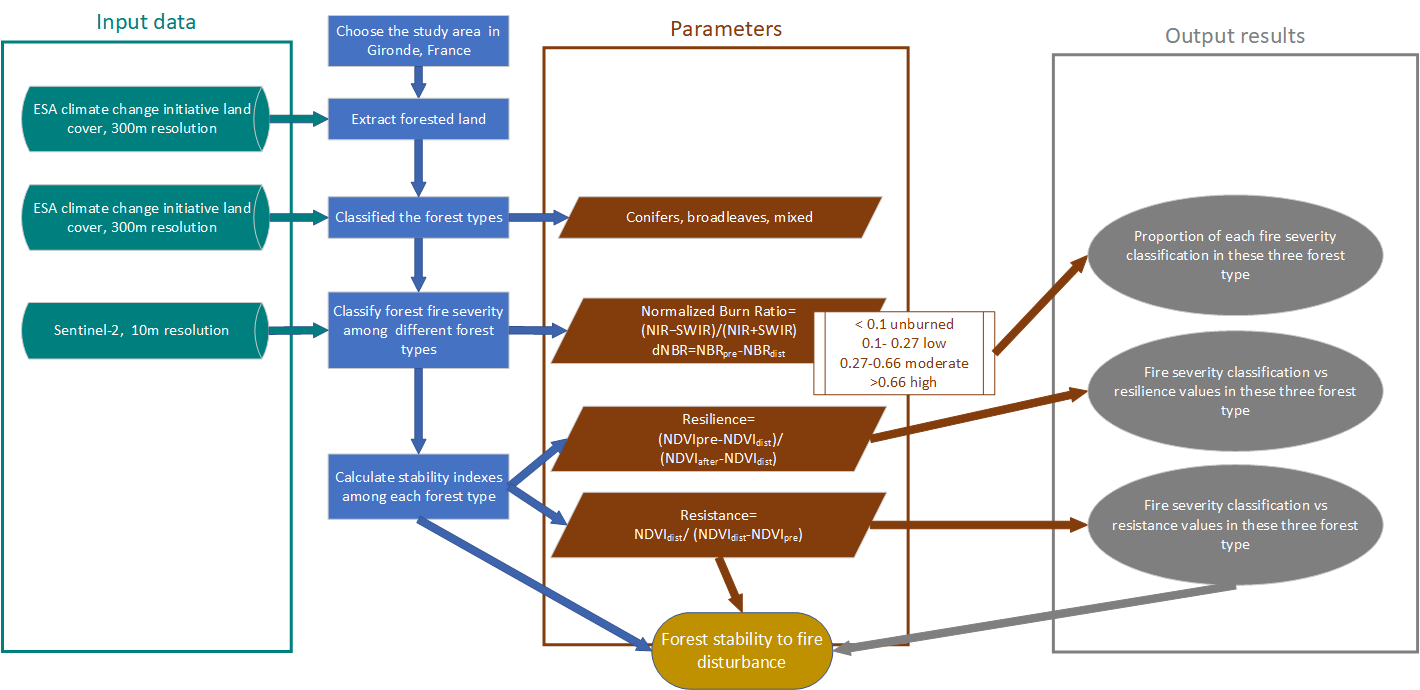

In [1]:
# STAC access
import pystac_client
import planetary_computer

# dataframes
import pandas as pd
import geopandas as gpd

# xarrays
import xarray as xr

# library for turning STAC objects into xarrays
import stackstac

# visualization
from matplotlib import pyplot as plt

# miscellanous
import numpy as np
from IPython.display import display
from datetime import date

### scattered plot
import seaborn as sns
import geogif

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

In [3]:
# Define the study area
aoi = {
  "type": "Polygon",
  "coordinates": [
    [
      [-1.254839, 44.423884],
      [-0.454832, 44.423884],
      [-0.454832, 44.763151],
      [-1.254839, 44.763151],
      [-1.254839, 44.423884]
    ]
  ]
}
# bounding box expressed in Lat/Lon
aoi_bounds = (-1.254839, 44.423884,-0.454832, 44.763151)

In [4]:
#### ESA land cover classification 300m resolution
# Define temporal range
daterange_forest_type= {"interval": ["2020-07-01T00:00:00Z", "2020-12-29T23:59:59Z"]}

# Define your search with CQL2 syntax
#search_esa = catalog.search(filter_lang="cql2-json", filter={
 # "op": "and",
 # "args": [
 #   {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
 #   {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange_forest_type]},
 #   {"op": "=", "args": [{"property": "collection"}, "esa-cci-lc"]}
#  ]
#})

time_range = "2020-07-01/2020-12-29"
search_esa = catalog.search(
    collections=['esa-cci-lc'],
    datetime=time_range,
    bbox=[-1.254839, 44.423884,-0.454832, 44.763151],#aoi_bounds,
    sortby="datetime"
)

items_esa=search_esa.item_collection()
len(items_esa)


1

In [5]:
display(items_esa)

id: C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1-N00W045
"bbox: [-45.0, 0.0, 0.0, 45.00000000000001]"
"title: ESA CCI Land Cover Map for Year 2020, Tile N00W045"
created: 2023-01-11T23:08:36.129624Z
datetime: None
proj:epsg: 4326
"proj:shape: [16200, 16200]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.002777777777777778, 0.0, -45.0, 0.0, -0.0027777777777777783, 45.00000000000001]"
start_datetime: 2020-01-01T00:00:00Z
esa_cci_lc:tile: N00W045


In [6]:
item_esa = items_esa[0]
assets_esa = [asset.title for asset in item_esa.assets.values()]
descriptions_esa = pd.DataFrame(assets_esa, 
                            columns=['Description'], 
                            index=pd.Series(item_esa.assets.keys(),
                                            name='asset_key'))
descriptions_esa

,Description
asset_key,
lccs_class,Land Cover Class Defined in the Land Cover Cla...
change_count,Number of Class Changes
processed_flag,Land Cover Map Processed Area Flag
observation_count,Number of Valid Observations
current_pixel_state,Land Cover Pixel Type Mask
tilejson,TileJSON with default rendering
rendered_preview,Rendered preview


In [7]:
asset = ['lccs_class']
FILL_VALUE = 2**16-1

array_esa = stackstac.stack(
                    items_esa,
                    assets = asset,
                    resolution=10,
                    epsg=32630,
                    dtype="uint16",
                    fill_value=FILL_VALUE,
                    bounds_latlon=aoi_bounds,
                    )
array_esa["proj:epsg"]=32630
display(array_esa)

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-4cd122809ddd9dd74da0b3974b87a8f9' (time: 1,
                                                                band: 1,
                                                                y: 3937, x: 6449)>
dask.array<fetch_raster_window, shape=(1, 1, 3937, 6449), dtype=uint16, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time                (time) datetime64[ns] NaT
    id                  (time) <U47 'C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1-...
  * band                (band) <U10 'lccs_class'
  * x                   (x) float64 6.381e+05 6.381e+05 ... 7.026e+05 7.026e+05
  * y                   (y) float64 4.96e+06 4.96e+06 ... 4.92e+06 4.92e+06
    esa_cci_lc:version  <U6 'v2.1.1'
    ...                  ...
    title               <U64 'Land Cover Class Defined in the Land Cover Clas...
    end_datetime        <U20 '2020-12-31T23:59:59Z'
    proj:shape          object {16200}
    raster:bands        object {'nodata': 0, 'sampling': 'area', 'data_type':...
    description         <U145 'Land cover class per pixel, defined using the ...
    epsg                int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(638110, 4920430, 702600, 4959...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 638110.00|\n| 0.00,-10.00, 4959800.00|\n| 0.0...
    resolution:  10

code  description

50 Tree cover, broadleaved, evergreen, closed to open (>15%)

60 Tree cover, broadleaved, deciduous, closed to open (>15%)
61 Tree cover, broadleaved, deciduous, closed (>40%)
62 Tree cover, broadleaved, deciduous, open (15-40%)

70 Tree cover, needleleaved, evergreen, closed to open (>15%)
71 Tree cover, needleleaved, evergreen, closed (>40%)
72 Tree cover, needleleaved, evergreen, open (15-40%)

80 Tree cover, needleleaved, deciduous, closed to open (>15%)
81 Tree cover, needleleaved, deciduous, closed (>40%)
82 Tree cover, needleleaved, deciduous, open (15-40%)

90 Tree cover, mixed leaf type (broadleaved and needleleaved)

(array([2546185.,  312181.,  533708., 9295747., 8340466.,   71659.,
         246799.,   35637.,  162558., 3844773.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.]),
 <BarContainer object of 10 artists>)

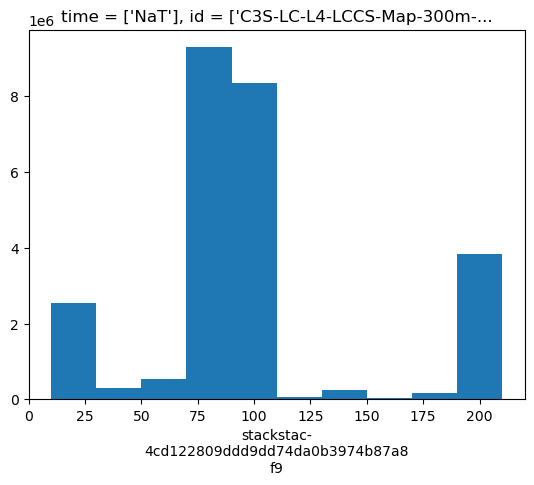

In [8]:
#array_esa.plot(robust=False)
array_esa.plot.hist()

/tmp/ipykernel_408/3745332473.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap_scalar_mappable, ticks=bounds, format='%1i')


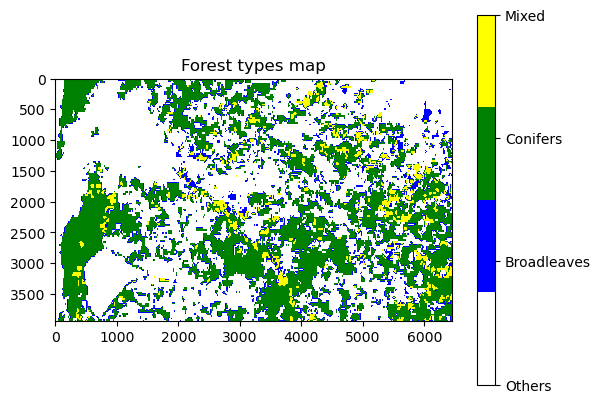

In [9]:
from matplotlib.colors import ListedColormap
forest_type = xr.where(array_esa == 60, 1,
                       xr.where(array_esa == 70, 2,
                                xr.where(array_esa == 90, 3, 0)))

forest_colors = ['white', 'blue', 'green', 'yellow']
cmap = ListedColormap(forest_colors)


bounds = [0, 1, 2, 3]
labels = ['Others', 'Broadleaves', 'Conifers', 'Mixed']
norm = plt.Normalize(vmin=0, vmax=3)

# 创建colorbar
cmap_scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cmap_scalar_mappable.set_array([]) 
cbar = plt.colorbar(cmap_scalar_mappable, ticks=bounds, format='%1i')
cbar.set_ticks(np.arange(0, 3.5, 1))
cbar.set_ticklabels(labels) 

plt.imshow(forest_type.squeeze(), cmap=cmap)
plt.title('Forest types map')
plt.show()

(array([14440782.,        0.,        0.,   533708.,        0.,        0.,
         9295747.,        0.,        0.,  1119476.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

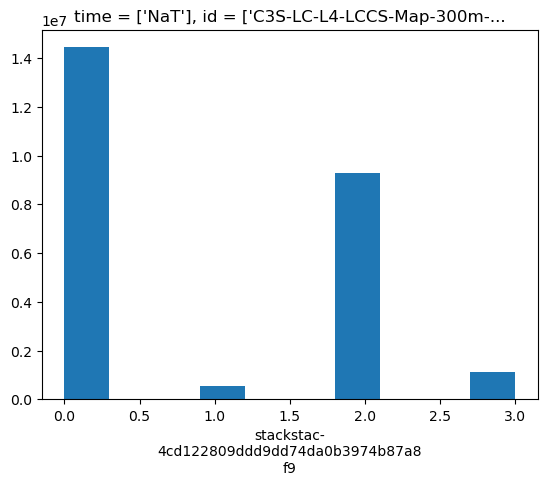

In [10]:
forest_type.plot.hist()

In [11]:
broad=xr.where((array_esa==60),array_esa,0)
broad_mask=broad.isin([0]).squeeze()
need=xr.where((array_esa==70),array_esa,0)
need_mask=need.isin([0]).squeeze()
mix=xr.where((array_esa==90),array_esa,0)
mix_mask=mix.isin([0]).squeeze()

#### extract forest area and forest types
calculate fire severity

In [12]:
####search for images from 2019-07-21 to 2023-08-01
cloud_nb = 20
search = catalog.search(
    collections=['sentinel-2-l2a'],
    datetime="2019-07-21/2023-08-01",
    bbox=[-1.274644, 44.450401,-1.151805, 44.660063],#aoi_bounds,
    query={"eo:cloud_cover": {"lt": cloud_nb}},
    sortby="datetime"
)
items=search.item_collection()
display(items)

id: S2B_MSIL2A_20190723T105629_R094_T30TXQ_20201005T184042
"bbox: [-1.7493896, 44.135250725162805, -0.33236694, 45.14675285555784]"
datetime: 2019-07-23T10:56:29.024000Z
platform: Sentinel-2B
proj:epsg: 32630
instruments: ['msi']
s2:mgrs_tile: 30TXQ
constellation: Sentinel 2
s2:granule_id: S2B_OPER_MSI_L2A_TL_ESRI_20201005T184045_A012418_T30TXQ_N02.12
eo:cloud_cover: 6.786255
s2:datatake_id: GS2B_20190723T105629_012418_N02.12


In [13]:
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09','B11', 'B12','SCL']
FILL_VALUE = 2**16-1
array = stackstac.stack(
                    items,
                    assets = bands,
                    resolution=10,####can use to determine the resolution
                    dtype="uint16",
                    fill_value=FILL_VALUE,
                    bounds_latlon=aoi_bounds
                    )
####resampling parameter is used to when change the resolution how the pixel are calculated
array

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-7df6f0579da8d04d3c68ebbe1e0df2ea' (time: 73,
                                                                band: 11,
                                                                y: 3937, x: 6449)>
dask.array<fetch_raster_window, shape=(73, 11, 3937, 6449), dtype=uint16, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2019-07-23...
    id                                       (time) <U54 'S2B_MSIL2A_20190723...
  * band                                     (band) <U3 'B02' 'B03' ... 'SCL'
  * x                                        (x) float64 6.381e+05 ... 7.026e+05
  * y                                        (y) float64 4.96e+06 ... 4.92e+06
    s2:mean_solar_azimuth                    (time) float64 147.5 ... 148.2
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 ... 20.0
    title                                    (band) <U36 'Band 2 - Blue - 10m...
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) object 0.49 0.56 ... None
    full_width_half_max                      (band) object 0.098 0.045 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(638110, 4920430, 702600, 4959...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 638110.00|\n| 0.00,-10.00, 4959800.00|\n| 0.0...
    resolution:  10

In [14]:
# Define the time periods for previous fire
time_periods = [
    ('2019-07-21', '2019-08-01'),
    ('2020-07-21', '2020-08-01'),
    ('2021-07-21', '2021-08-01')
]

# Create an empty list to store selected data arrays
selected_data = []

# Loop through each time period and select data from the 'array' dataset
for start_date, end_date in time_periods:
    selected_data.append(array.sel(time=slice(start_date, end_date)))

# Concatenate the selected data arrays along the 'time' dimension
array_pre = xr.concat(selected_data, dim='time')
array_pre

<xarray.DataArray 'stackstac-7df6f0579da8d04d3c68ebbe1e0df2ea' (time: 3,
                                                                band: 11,
                                                                y: 3937, x: 6449)>
dask.array<concatenate, shape=(3, 11, 3937, 6449), dtype=uint16, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2019-07-23...
    id                                       (time) <U54 'S2B_MSIL2A_20190723...
  * band                                     (band) <U3 'B02' 'B03' ... 'SCL'
  * x                                        (x) float64 6.381e+05 ... 7.026e+05
  * y                                        (y) float64 4.96e+06 ... 4.92e+06
    s2:mean_solar_azimuth                    (time) float64 147.5 148.3 147.3
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 ... 20.0
    title                                    (band) <U36 'Band 2 - Blue - 10m...
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) object 0.49 0.56 ... None
    full_width_half_max                      (band) object 0.098 0.045 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(638110, 4920430, 702600, 4959...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 638110.00|\n| 0.00,-10.00, 4959800.00|\n| 0.0...
    resolution:  10

In [15]:
array_dist =array.sel(time=slice('2022-07-21', '2022-08-01'))
array_dist

<xarray.DataArray 'stackstac-7df6f0579da8d04d3c68ebbe1e0df2ea' (time: 1,
                                                                band: 11,
                                                                y: 3937, x: 6449)>
dask.array<getitem, shape=(1, 11, 3937, 6449), dtype=uint16, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-08-01...
    id                                       (time) <U54 'S2A_MSIL2A_20220801...
  * band                                     (band) <U3 'B02' 'B03' ... 'SCL'
  * x                                        (x) float64 6.381e+05 ... 7.026e+05
  * y                                        (y) float64 4.96e+06 ... 4.92e+06
    s2:mean_solar_azimuth                    (time) float64 149.3
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 ... 20.0
    title                                    (band) <U36 'Band 2 - Blue - 10m...
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) object 0.49 0.56 ... None
    full_width_half_max                      (band) object 0.098 0.045 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(638110, 4920430, 702600, 4959...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 638110.00|\n| 0.00,-10.00, 4959800.00|\n| 0.0...
    resolution:  10

In [17]:
array_dist_need_mask=array_dist.where(~need_mask)

In [18]:
s2_ref_crs = array_dist_need_mask.crs
s2_ref_trf = array_dist_need_mask.transform
s2_ref_shape = (array_dist_need_mask['x'].size, array_dist_need_mask['y'].size)
print(f'- S2 CRS: {s2_ref_crs}')
print(f'- S2 affine transform: \n{s2_ref_trf}')
print(f'- S2 XY dimension: {s2_ref_shape}')

- S2 CRS: epsg:32630
- S2 affine transform: 
| 10.00, 0.00, 638110.00|
| 0.00,-10.00, 4959800.00|
| 0.00, 0.00, 1.00|
- S2 XY dimension: (6449, 3937)


In [19]:
import geopandas as gpd
from rasterio import features
field = gpd.read_file('sample.geojson')
field_to_raster_crs = field.to_crs(s2_ref_crs)
geom = field_to_raster_crs[['geometry', 'fid']].values.tolist()

field_cropped_raster = features.rasterize(geom, out_shape=s2_ref_shape, fill=0, transform=s2_ref_trf)
field_cropped_raster_xarr = xr.DataArray(field_cropped_raster)

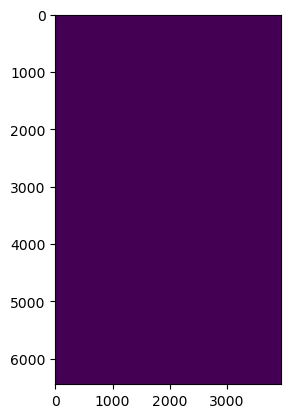

In [20]:
import matplotlib.pyplot as plt

plt.imshow(field_cropped_raster_xarr)

In [21]:
from xrspatial import zonal_stats as xrspatial_zs
import time

def s2_zonal(array_dist, band, field_cropped_raster_xarr):
    s2_band = array_dist.sel(band=bands).squeeze('time').values
    s2_band_xarr = xr.DataArray(s2_band)
    sign_spectral = xrspatial_zs(field_cropped_raster_xarr, 
                                 s2_band_xarr, 
                                 stats_funcs = ['count','min','mean','max'], nodata_values = 0)
    
    out_names = dict()
    for i in sign_spectral.columns:
        out_names[i] = '{}_{}'.format(band, i)
    sign_spectral.rename(columns = out_names, inplace = True)

    return sign_spectral

In [22]:
final = field.copy()

start_time = time.time()
end_time = time.time()

duration = (end_time - start_time)
minutes, seconds =  divmod(duration, 60)
print(f'duration: {int(minutes)} min {seconds:.2f} sec')

duration: 0 min 0.00 sec


In [23]:
cols = [c for c in final.columns if c.lower()[3:] != '_zone']
finalb = final[cols]
finalb.head()

,fid,landcover,geometry
0,1,urban01,"POLYGON ((3.91165 43.57305, 3.91165 43.57490, ..."
1,2,urban02,"POLYGON ((3.93971 43.57152, 3.93971 43.57383, ..."
2,3,urban03,"POLYGON ((3.87511 43.60920, 3.87511 43.61179, ..."
3,4,baresoil01,"POLYGON ((3.93528 43.62391, 3.93528 43.62714, ..."
4,5,baresoil02,"POLYGON ((3.98472 43.64148, 3.98472 43.64420, ..."


In [25]:
from rasterstats import zonal_stats as rasterstats_zs

def s2_zonal2(stac_item, band, geodf, geodf_id):
    fid = field_to_raster_crs[geodf_id]
    zs = rasterstats_zs(geodf, stac_item.assets[band].href, stats="count min mean max median")
    sign_spectral = pd.DataFrame(zs)
    sign_spectral = pd.concat([fid, sign_spectral], axis=1)
        
    out_names = dict()
    for i in sign_spectral.columns:
        out_names[i] = '{}_{}'.format(band, i)
    sign_spectral.rename(columns = out_names, inplace = True)

    return sign_spectral

In [26]:
time_range = "2022-07-21/2022-08-01"
cloud_nb=20
search_dist = catalog.search(
    collections=['sentinel-2-l2a'],
    datetime=time_range,
    bbox=[-1.274644, 44.450401,-1.151805, 44.660063],#aoi_bounds,
    query={"eo:cloud_cover": {"lt": cloud_nb}}
)
item = search_dist.item_collection()
item=item[0]

In [29]:
!pip install rasterstats

  Using cached rasterstats-0.19.0-py3-none-any.whl (16 kB)
  Using cached simplejson-3.19.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (144 kB)


In [32]:
import time
final2 = field.copy()

start_time = time.time()
for band in bands:
    df = s2_zonal2(item, band, field_to_raster_crs, "fid")
    final2 = final2.merge(df, left_on='fid', right_on='{}_fid'.format(band))
end_time = time.time()

duration = (end_time - start_time)
minutes, seconds =  divmod(duration, 60)
print(f'duration: {int(minutes)} min {seconds:.2f} sec')

duration: 0 min 0.68 sec


In [33]:
cols = [c for c in final2.columns if c.lower()[3:] != '_fid']
final2b = final2[cols]
final2b.head()

,fid,landcover,geometry,B02_count,B02_min,B02_mean,B02_max,B02_median,B03_count,B03_min,...,B12_count,B12_min,B12_mean,B12_max,B12_median,SCL_count,SCL_min,SCL_mean,SCL_max,SCL_median
0,1,urban01,"POLYGON ((3.91165 43.57305, 3.91165 43.57490, ...",0,None,None,None,None,0,None,...,0,None,None,None,None,0,None,None,None,None
1,2,urban02,"POLYGON ((3.93971 43.57152, 3.93971 43.57383, ...",0,None,None,None,None,0,None,...,0,None,None,None,None,0,None,None,None,None
2,3,urban03,"POLYGON ((3.87511 43.60920, 3.87511 43.61179, ...",0,None,None,None,None,0,None,...,0,None,None,None,None,0,None,None,None,None
3,4,baresoil01,"POLYGON ((3.93528 43.62391, 3.93528 43.62714, ...",0,None,None,None,None,0,None,...,0,None,None,None,None,0,None,None,None,None
4,5,baresoil02,"POLYGON ((3.98472 43.64148, 3.98472 43.64420, ...",0,None,None,None,None,0,None,...,0,None,None,None,None,0,None,None,None,None


In [34]:
array_post =array.sel(time=slice('2023-07-21', '2023-08-01'))
array_post

<xarray.DataArray 'stackstac-7df6f0579da8d04d3c68ebbe1e0df2ea' (time: 1,
                                                                band: 11,
                                                                y: 3937, x: 6449)>
dask.array<getitem, shape=(1, 11, 3937, 6449), dtype=uint16, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2023-07-27...
    id                                       (time) <U54 'S2A_MSIL2A_20230727...
  * band                                     (band) <U3 'B02' 'B03' ... 'SCL'
  * x                                        (x) float64 6.381e+05 ... 7.026e+05
  * y                                        (y) float64 4.96e+06 ... 4.92e+06
    s2:mean_solar_azimuth                    (time) float64 148.2
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 ... 20.0
    title                                    (band) <U36 'Band 2 - Blue - 10m...
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) object 0.49 0.56 ... None
    full_width_half_max                      (band) object 0.098 0.045 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(638110, 4920430, 702600, 4959...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 638110.00|\n| 0.00,-10.00, 4959800.00|\n| 0.0...
    resolution:  10

In [35]:
####NBR NDVI during fire
##nbr= (NIR−SWIR)/(NIR+SWIR)
red_dist = array_dist.sel(band="B04").astype('float')
nir_dist = array_dist.sel(band="B08").astype('float')
mir_dist = array_dist.sel(band="B12").astype('float')

nbr_dist = (nir_dist-mir_dist)/(nir_dist+mir_dist)
ndvi_dist= (nir_dist-red_dist)/(nir_dist+red_dist)

In [36]:
###NBR and NDVI after fire
red_post = array_post.sel(band="B04").astype('float')
nir_post = array_post.sel(band="B08").astype('float')
mir_post = array_post.sel(band="B12").astype('float')

nbr_post = (nir_post-mir_post)/(nir_post+mir_post)
ndvi_post= (nir_post-red_post)/(nir_post+red_post)

In [37]:
#### NBR NDVI previous fire
red_pre = array_pre.sel(band="B04").astype('float')
red_pre=red_pre.mean(axis=0)
nir_pre = array_pre.sel(band="B08").astype('float')
nir_pre=nir_pre.mean(axis=0)
mir_pre = array_pre.sel(band="B12").astype('float')
mir_pre=mir_pre.mean(axis=0)

nbr_pre = (nir_pre-mir_pre)/(nir_pre+mir_pre)
ndvi_pre= (nir_pre-red_pre)/(nir_pre+red_pre)

In [38]:
###dNBR
dnbr=nbr_pre.squeeze()-nbr_dist.squeeze()
dnbr

<xarray.DataArray 'stackstac-7df6f0579da8d04d3c68ebbe1e0df2ea' (y: 3937, x: 6449)>
dask.array<sub, shape=(3937, 6449), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/38)
  * x                                        (x) float64 6.381e+05 ... 7.026e+05
  * y                                        (y) float64 4.96e+06 ... 4.92e+06
    proj:epsg                                int64 32630
    s2:saturated_defective_pixel_percentage  float64 0.0
    constellation                            <U10 'Sentinel 2'
    instruments                              <U3 'msi'
    ...                                       ...
    platform                                 <U11 'Sentinel-2A'
    s2:high_proba_clouds_percentage          float64 0.4023
    s2:medium_proba_clouds_percentage        float64 0.9895
    s2:product_uri                           <U65 'S2A_MSIL2A_20220801T105631...
    s2:datastrip_id                          <U64 'S2A_OPER_MSI_L2A_DS_ESRI_2...
    s2:unclassified_percentage               float64 0.8455

NBR of each forest types

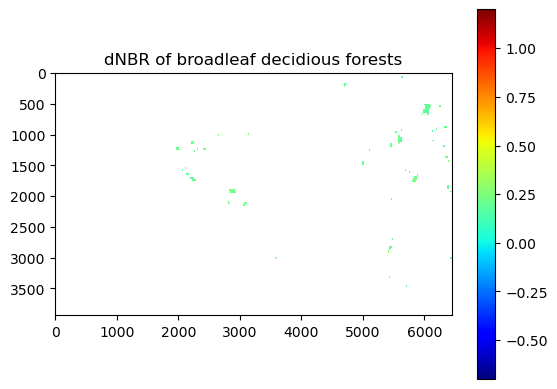

In [39]:
###dNBR of broadleaf decidious
dnbr_broad=dnbr.where(~broad_mask)
plt.imshow(dnbr_broad.squeeze(),vmin=-0.70,vmax=1.2,cmap="jet")
plt.colorbar()
plt.title('dNBR of broadleaf decidious forests')
plt.show()

In [40]:
dnbr_broad_numpy = dnbr_broad.values
dnbr_broad_numpy = dnbr_broad_numpy[~np.isnan(dnbr_broad_numpy)]

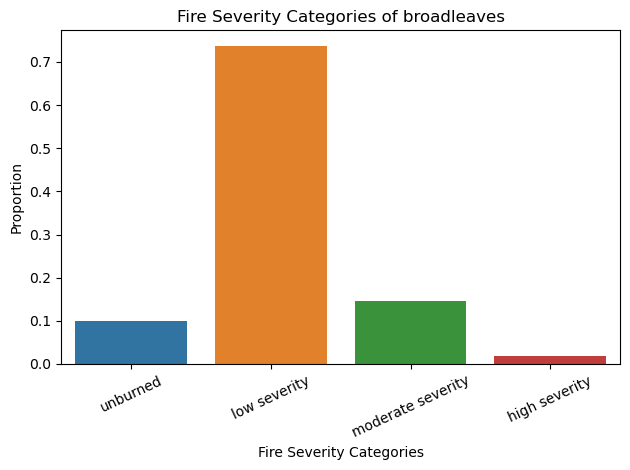

In [41]:
###calculating the fire Severity Categories of broadleaves
dnbr_broad_numpy = dnbr_broad.values
dnbr_broad_numpy = dnbr_broad_numpy[~np.isnan(dnbr_broad_numpy)]

dnbr_categories = []

# Categorize the values based on fire severity
for value in dnbr_broad_numpy:
    if value < 0.1:
        dnbr_categories.append("unburned")
    elif 0.1 <= value <= 0.27:
        dnbr_categories.append("low severity")
    elif 0.27 <= value <= 0.66:
        dnbr_categories.append("moderate severity")
    else:
        dnbr_categories.append("high severity")

dnbr_categories_series = pd.Series(dnbr_categories, dtype="category")

category_order = ["unburned", "low severity", "moderate severity", "high severity"]

dnbr_categories_series = dnbr_categories_series.cat.reorder_categories(category_order)

# Create a DataFrame for plotting
dnbr_broad_data = pd.DataFrame({'Fire Severity Categories': dnbr_categories_series, 'dNBR Values': dnbr_broad_numpy})

# Calculate the proportion of each category
dnbr_broad_proportions = dnbr_broad_data['Fire Severity Categories'].value_counts(normalize=True)

# Create a bar plot of category proportions
sns.barplot(x=dnbr_broad_proportions.index, y=dnbr_broad_proportions.values)
plt.ylabel("Proportion")
plt.title("Fire Severity Categories of broadleaves")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

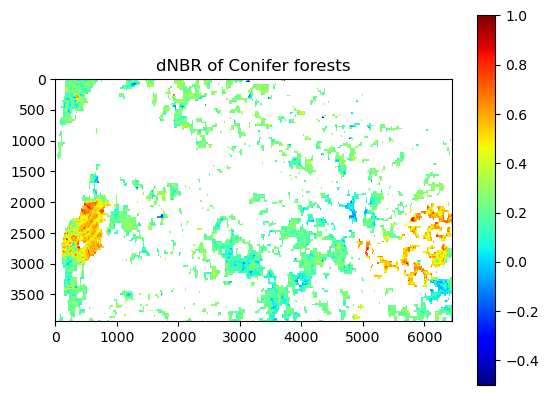

In [43]:
###NBR of Conifer decidious
dnbr_need=dnbr.where(~need_mask)
plt.imshow(dnbr_need.squeeze(),vmin=-0.5,vmax=1.0,cmap="jet")
plt.colorbar()
plt.title('dNBR of Conifer forests')
plt.show()

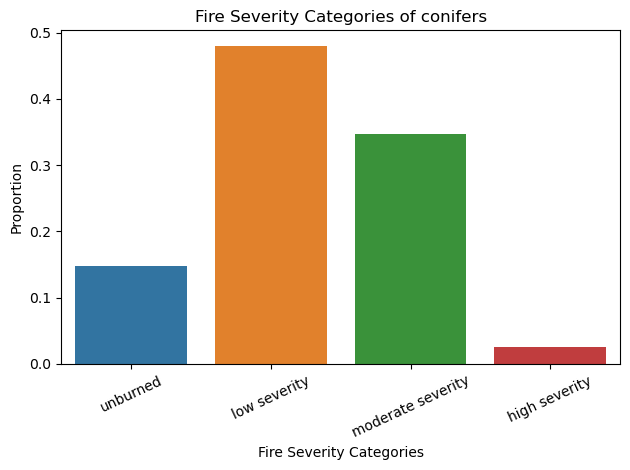

In [44]:
###calculating the fire Severity Categories of conifers
dnbr_need_numpy = dnbr_need.values
dnbr_need_numpy = dnbr_need_numpy[~np.isnan(dnbr_need_numpy)]

dnbr_categories = []

# Categorize the values based on fire severity
for value in dnbr_need_numpy:
    if value < 0.1:
        dnbr_categories.append("unburned")
    elif 0.1 <= value <= 0.27:
        dnbr_categories.append("low severity")
    elif 0.27 <= value <= 0.66:
        dnbr_categories.append("moderate severity")
    else:
        dnbr_categories.append("high severity")

dnbr_categories_series = pd.Series(dnbr_categories, dtype="category")

category_order = ["unburned", "low severity", "moderate severity", "high severity"]

dnbr_categories_series = dnbr_categories_series.cat.reorder_categories(category_order)

# Create a DataFrame for plotting
dnbr_need_data = pd.DataFrame({'Fire Severity Categories': dnbr_categories_series, 'dNBR Values': dnbr_need_numpy})

# Calculate the proportion of each category
dnbr_need_proportions = dnbr_need_data['Fire Severity Categories'].value_counts(normalize=True)

# Create a bar plot of category proportions
sns.barplot(x=dnbr_need_proportions.index, y=dnbr_need_proportions.values)
plt.ylabel("Proportion")
plt.title("Fire Severity Categories of conifers")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

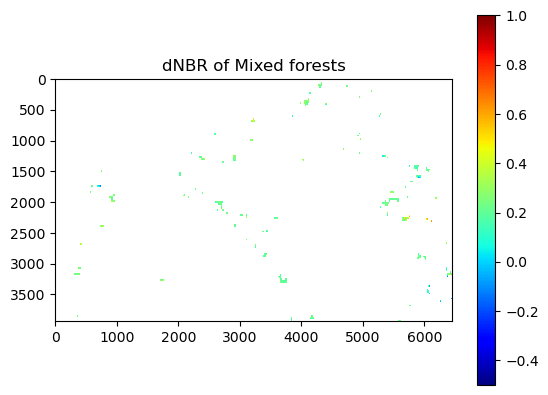

In [45]:
###NBR of Mixed decidious
dnbr_mix=dnbr.where(~mix_mask)
plt.imshow(dnbr_mix.squeeze(),vmin=-0.5,vmax=1.0,cmap="jet")
plt.colorbar()
plt.title('dNBR of Mixed forests')
plt.show()

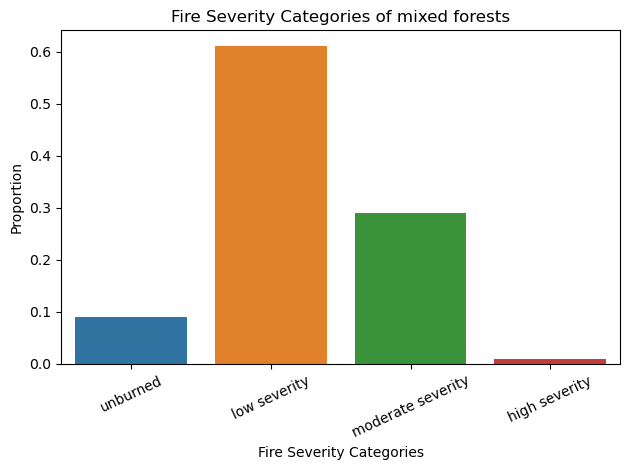

In [46]:
###calculating the fire Severity Categories of mixed forests
dnbr_mix_numpy = dnbr_mix.values
dnbr_mix_numpy = dnbr_mix_numpy[~np.isnan(dnbr_mix_numpy)]

dnbr_categories = []

# Categorize the values based on fire severity
for value in dnbr_mix_numpy:
    if value < 0.1:
        dnbr_categories.append("unburned")
    elif 0.1 <= value <= 0.27:
        dnbr_categories.append("low severity")
    elif 0.27 <= value <= 0.66:
        dnbr_categories.append("moderate severity")
    else:
        dnbr_categories.append("high severity")

dnbr_categories_series = pd.Series(dnbr_categories, dtype="category")

category_order = ["unburned", "low severity", "moderate severity", "high severity"]

dnbr_categories_series = dnbr_categories_series.cat.reorder_categories(category_order)

dnbr_mix_data = pd.DataFrame({'Fire Severity Categories': dnbr_categories_series, 'dNBR Values': dnbr_mix_numpy})

# Calculate the proportion of each category
dnbr_mix_proportions = dnbr_mix_data['Fire Severity Categories'].value_counts(normalize=True)

# Create a bar plot of category proportions
sns.barplot(x=dnbr_mix_proportions.index, y=dnbr_mix_proportions.values)
plt.ylabel("Proportion")
plt.title("Fire Severity Categories of mixed forests")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [49]:
###resilience
resilience= abs((ndvi_pre.squeeze()-ndvi_dist.squeeze())/(ndvi_post.squeeze()-ndvi_dist.squeeze()))

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


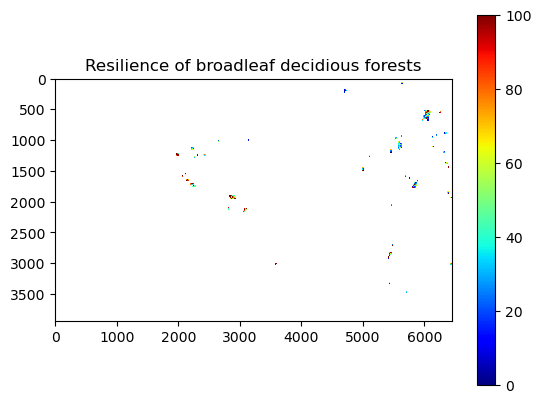

In [48]:
####resilience of broadleaves
resilience_broad=resilience.where(~broad_mask)
plt.imshow(resilience_broad.squeeze(),vmin=0,vmax=100,cmap="jet")
plt.colorbar()
plt.title('Resilience of broadleaf decidious forests')
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


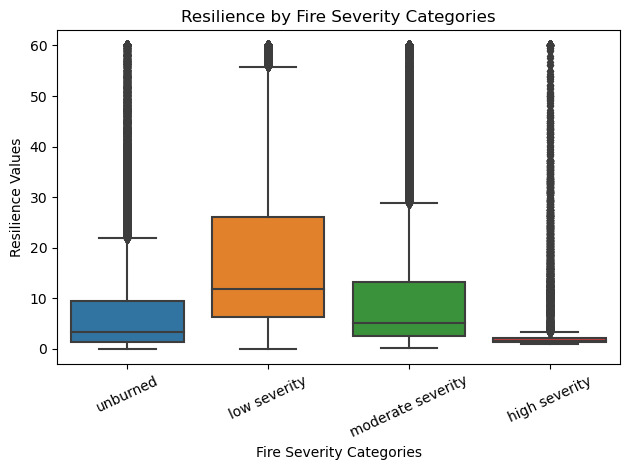

In [55]:
###plotting fire severity vs resilience of broadleaves
resilience_broad_numpy = resilience_broad.values
resilience_broad_numpy = resilience_broad_numpy[~np.isnan(resilience_broad_numpy)]
resilience_broad_data = pd.concat([dnbr_broad_data, pd.Series(resilience_broad_numpy, name='Resilience')], axis=1)
resilience_broad_data['Resilience'] = np.clip(resilience_broad_data['Resilience'], 0,60)
sns.boxplot(x='Fire Severity Categories', y='Resilience', data=resilience_broad_data)
plt.ylabel("Resilience Values")
plt.title("Resilience by Fire Severity Categories")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


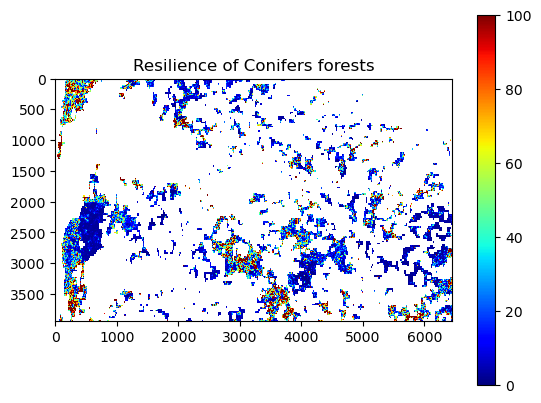

In [56]:
####resilience of conifers
resilience_need=resilience.where(~need_mask)
plt.imshow(resilience_need.squeeze(),vmin=0,vmax=100,cmap="jet")
plt.colorbar()
plt.title('Resilience of Conifers forests')
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


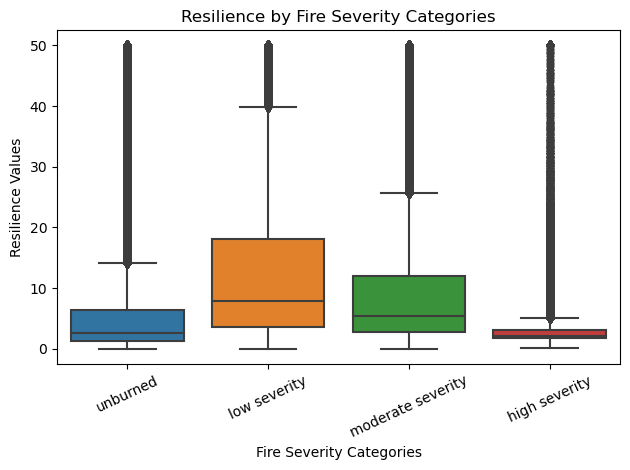

In [58]:
###plotting fire severity vs resilience of conifers
resilience_need_numpy = resilience_need.values
resilience_need_numpy = resilience_need_numpy[~np.isnan(resilience_need_numpy)]
resilience_need_data = pd.concat([dnbr_need_data, pd.Series(resilience_need_numpy, name='Resilience')], axis=1)
resilience_need_data['Resilience'] = np.clip(resilience_need_data['Resilience'], 0, 50)
sns.boxplot(x='Fire Severity Categories', y='Resilience', data=resilience_need_data)
plt.ylabel("Resilience Values")
plt.title("Resilience by Fire Severity Categories")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


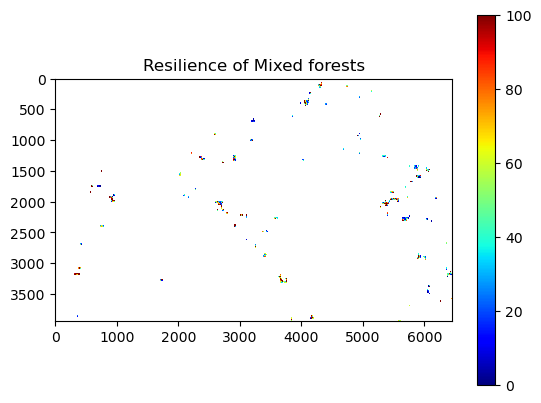

In [59]:
####resilience of mixed forests
resilience_mix=resilience.where(~mix_mask)
plt.imshow(resilience_mix.squeeze(),vmin=0,vmax=100,cmap="jet")
plt.colorbar()
plt.title('Resilience of Mixed forests')
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


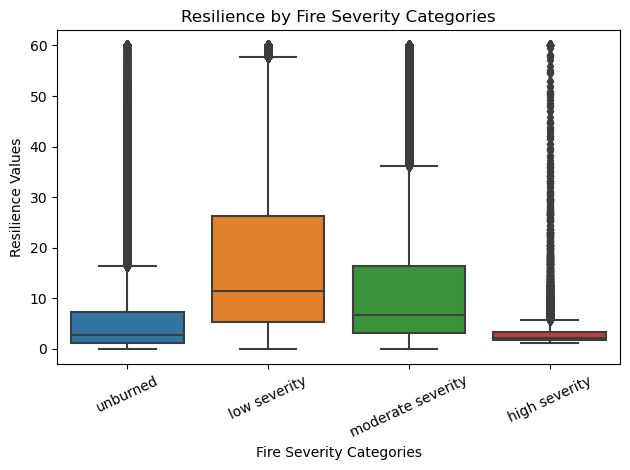

In [61]:
###plotting fire severity vs resilience of mixed
resilience_mix_numpy = resilience_mix.values
resilience_mix_numpy = resilience_mix_numpy[~np.isnan(resilience_mix_numpy)]
resilience_mix_data = pd.concat([dnbr_mix_data, pd.Series(resilience_mix_numpy, name='Resilience')], axis=1)
resilience_mix_data['Resilience'] = np.clip(resilience_mix_data['Resilience'],  0, 60)
sns.boxplot(x='Fire Severity Categories', y='Resilience', data=resilience_mix_data)
plt.ylabel("Resilience Values")
plt.title("Resilience by Fire Severity Categories")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [67]:
###resistance
resistance = ndvi_dist.squeeze()/abs((ndvi_dist.squeeze()-ndvi_pre.squeeze()))

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


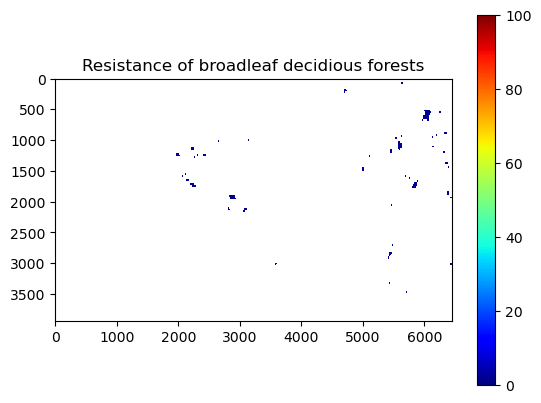

In [68]:
####resistance of broadleaves
resistance_broad=resistance.where(~broad_mask)
plt.imshow(resistance_broad.squeeze(),vmin=0,vmax=100,cmap="jet")
plt.colorbar()
plt.title('Resistance of broadleaf decidious forests')
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


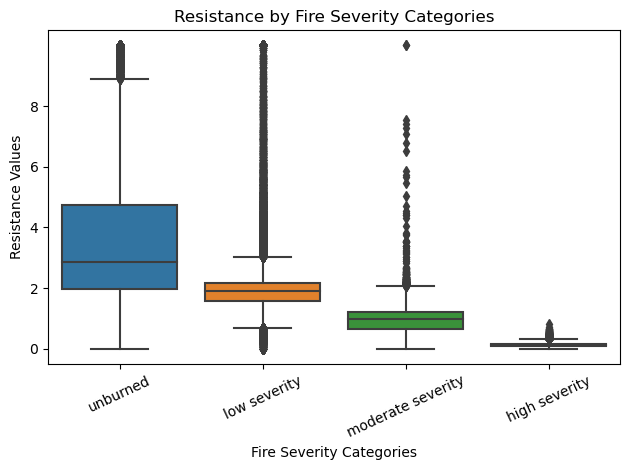

In [78]:
###plotting fire severity vs resistance of broadleaves
resistance_broad_numpy = resistance_broad.values
resistance_broad_numpy = resistance_broad_numpy[~np.isnan(resistance_broad_numpy)]
resistance_broad_data = pd.concat([dnbr_broad_data, pd.Series(resistance_broad_numpy, name='Resistance')], axis=1)
resistance_broad_data['Resistance'] = np.clip(resistance_broad_data['Resistance'], 0, 10)
sns.boxplot(x='Fire Severity Categories', y='Resistance', data=resistance_broad_data)
plt.ylabel("Resistance Values")
plt.title("Resistance by Fire Severity Categories")
plt.xticks(rotation=25)
desired_ticks = np.arange(0, 10, 2)
plt.yticks(desired_ticks)
plt.tight_layout()
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


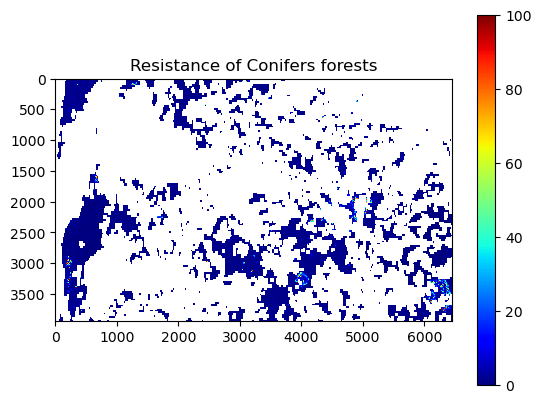

In [70]:
####resistance of conifers
resistance_need=resistance.where(~need_mask)
plt.imshow(resistance_need.squeeze(),vmin=0,vmax=100,cmap="jet")
plt.colorbar()
plt.title('Resistance of Conifers forests')
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


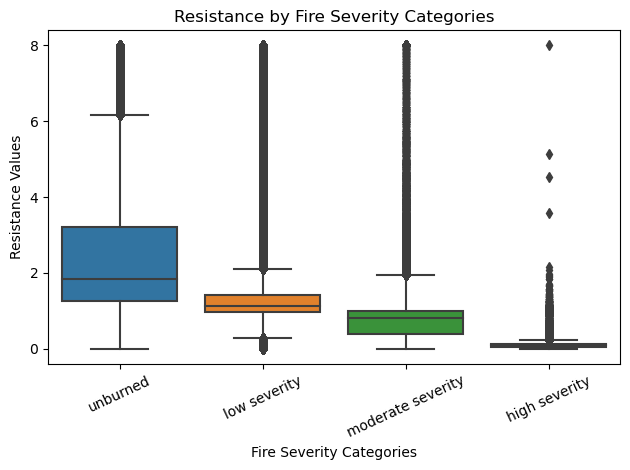

In [80]:
###plotting fire severity vs resistance of conifers
resistance_need_numpy = resistance_need.values
resistance_need_numpy = resistance_need_numpy[~np.isnan(resistance_need_numpy)]
resistance_need_data = pd.concat([dnbr_need_data, pd.Series(resistance_need_numpy, name='Resistance')], axis=1)
resistance_need_data['Resistance'] = np.clip(resistance_need_data['Resistance'], 0, 8)
sns.boxplot(x='Fire Severity Categories', y='Resistance', data=resistance_need_data)
plt.ylabel("Resistance Values")
plt.title("Resistance by Fire Severity Categories")
plt.xticks(rotation=25)
desired_ticks = np.arange(0, 10, 2)
plt.yticks(desired_ticks)
plt.tight_layout()
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


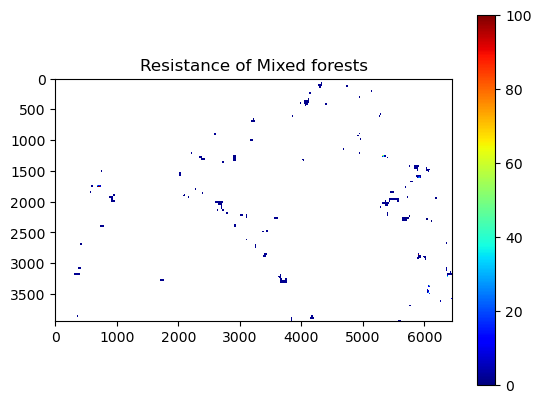

In [72]:
####resistance of mixed forests
resistance_mix=resistance.where(~mix_mask)
plt.imshow(resistance_mix.squeeze(),vmin=0,vmax=100,cmap="jet")
plt.colorbar()
plt.title('Resistance of Mixed forests')
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


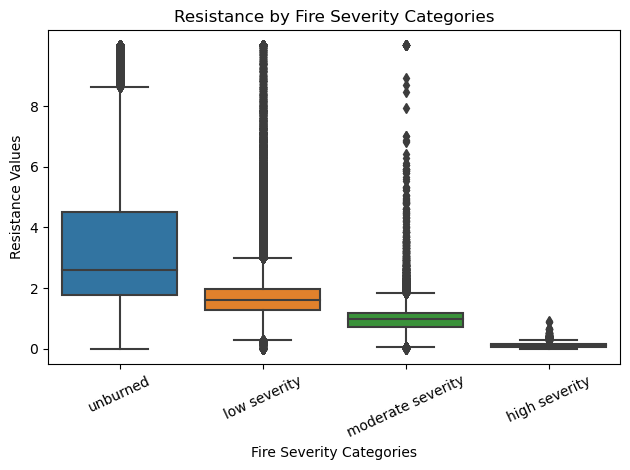

In [81]:
###plotting fire severity vs resistance of mixed
resistance_mix_numpy = resistance_mix.values
resistance_mix_numpy = resistance_mix_numpy[~np.isnan(resistance_mix_numpy)]
resistance_mix_data = pd.concat([dnbr_mix_data, pd.Series(resistance_mix_numpy, name='Resistance')], axis=1)
resistance_mix_data['Resistance'] = np.clip(resistance_mix_data['Resistance'],0,10)
sns.boxplot(x='Fire Severity Categories', y='Resistance', data=resistance_mix_data)
plt.ylabel("Resistance Values")
plt.title("Resistance by Fire Severity Categories")
plt.xticks(rotation=25)
desired_ticks = np.arange(0, 10, 2)
plt.yticks(desired_ticks)
plt.tight_layout()
plt.show()

In [82]:
cloud_nb = 20
today = date.today()
last_month = today.replace(month=today.month-1).strftime('%Y-%m')
time_range = f"2022-07-21/2023-08-01"#{last_month}"
search = catalog.search(
    collections=['sentinel-2-l2a'],
    datetime="2022-07-21/2023-08-01",
    bbox=[-1.274644, 44.450401,-1.151805, 44.660063],#aoi_bounds,
    query={"eo:cloud_cover": {"lt": cloud_nb}},
    sortby="datetime"
)
items = search.item_collection()
time_steps_pc = len(items)

bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'SCL']
FILL_VALUE = 2**16-1
array_post_all = stackstac.stack(
                    items,
                    assets = bands,
                    resolution=10,
                    dtype="uint16",
                    fill_value=FILL_VALUE,
                    bounds_latlon=aoi_bounds,
                    chunksize= (time_steps_pc, 1, 'auto', 'auto')
                    )
array_post_all.drop_duplicates('time')
array_post_all

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-9b8761e4e69b1b7a75ca5046c261b2cb' (time: 15,
                                                                band: 10,
                                                                y: 3937, x: 6449)>
dask.array<fetch_raster_window, shape=(15, 10, 3937, 6449), dtype=uint16, chunksize=(15, 1, 1652, 2707), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-08-01...
    id                                       (time) <U54 'S2A_MSIL2A_20220801...
  * band                                     (band) <U3 'B02' 'B03' ... 'SCL'
  * x                                        (x) float64 6.381e+05 ... 7.026e+05
  * y                                        (y) float64 4.96e+06 ... 4.92e+06
    s2:mean_solar_azimuth                    (time) float64 149.3 ... 148.2
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 ... 20.0
    title                                    (band) <U36 'Band 2 - Blue - 10m...
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) object 0.49 0.56 ... None
    full_width_half_max                      (band) object 0.098 0.045 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(638110, 4920430, 702600, 4959...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 638110.00|\n| 0.00,-10.00, 4959800.00|\n| 0.0...
    resolution:  10

In [83]:
# mask creation
SCL = array.sel(band = 'SCL')
mask = SCL.isin([3, 8, 9, 10])
# application of mask
result = array.where(~mask) #, 0) argument 2 = new output value for nan
source = result.sel(band=["B08", "B04", "B03"])
#interpolated = source.interpolate_na(dim="time", method="linear", use_coordinate = 'time')
#interpolated = interpolated.ffill(dim= 'time')
#interpolated.data = interpolated.data.astype(np.uint16)
#interpolated.plot.imshow(col_wrap=3, col="time", rgb="band", vmax=2500, size=4)

In [84]:
composites = result.resample(time="Q").median("time")
composites

<xarray.DataArray 'stackstac-7df6f0579da8d04d3c68ebbe1e0df2ea' (time: 17,
                                                                band: 11,
                                                                y: 3937, x: 6449)>
dask.array<stack, shape=(17, 11, 3937, 6449), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * band                                     (band) <U3 'B02' 'B03' ... 'SCL'
  * x                                        (x) float64 6.381e+05 ... 7.026e+05
  * y                                        (y) float64 4.96e+06 ... 4.92e+06
    proj:epsg                                int64 32630
    s2:saturated_defective_pixel_percentage  float64 0.0
    constellation                            <U10 'Sentinel 2'
    ...                                       ...
    s2:mgrs_tile                             <U5 '30TXQ'
    s2:datatake_type                         <U8 'INS-NOBS'
    sat:relative_orbit                       int64 94
    proj:bbox                                object {600000.0, 5000040.0, 489...
    epsg                                     int64 32630
  * time                                     (time) datetime64[ns] 2019-09-30...
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(638110, 4920430, 702600, 4959...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 638110.00|\n| 0.00,-10.00, 4959800.00|\n| 0.0...
    resolution:  10

In [ ]:
import geogif
rgb = composites.sel(band=["B04", "B03", "B02"])
cleaned = rgb.ffill("time")[1:]
gif_img = geogif.dgif(cleaned, fps=8).compute()
gif_img

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
